In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from interp_utils.node_stats.all_stats import make_all_stats
from circuits_benchmark.utils.get_cases import get_names_of_working_cases, get_cases
import pandas as pd
from typing import Literal


lens: Literal['logit_lens', 'tuned_lens'] = 'logit_lens'


make = False
csv_file = "interp_results/siit_node_stats_all_cases.csv"
if make:
    from interp_utils.node_stats.plotting import make_dict_from_stats, make_df_from_stats
    cases = [ case for case in get_names_of_working_cases() if 'ioi' not in case ]
    cases = get_cases(indices=cases)
    all_stats = make_all_stats(
        cases=cases,
        only_siit=True,
    )
    siit_stats = make_df_from_stats(make_dict_from_stats(all_stats, "siit"))
    for row in siit_stats.iterrows():
        if row[1]["node"] == "blocks.0.attn.hook_result, head  0" and row[1]["status"] == "in_circuit" and row[1]["run"] == "8":
            print("Removing case 8 constant node for siit_stats")
            siit_stats.loc[row[0], "status"] = "not_in_circuit"

    siit_stats.to_csv(csv_file, index=False)
else:
    siit_stats = pd.read_csv(csv_file)
    cases = siit_stats['run'].unique()


print(cases)

[11 13 18 19 20 21 26 29  3 33 34 35 36 37  4  8]


In [3]:
lens_stats = {}

for case in cases:
    pearsons_for_case = pd.read_csv(f"interp_results/{case}/{lens}/combined_pearson.csv")
    p_value_for_case = pd.read_csv(f"interp_results/{case}/{lens}/combined_p_values.csv")
    lens_stats[case] = {
        'pearsons': pearsons_for_case,
        'p_values': p_value_for_case,
    }

print(lens_stats.keys())

dict_keys([11, 13, 18, 19, 20, 21, 26, 29, 3, 33, 34, 35, 36, 37, 4, 8])


In [4]:
import re

lens_node_templates = {
    "mlp" : """{layer}_mlp_out""",
    "attn": """L{layer}H{head}""",
    "in_circuit": "(IC)"
}

siit_node_templates = {
    "mlp": """blocks.{layer}.mlp.hook_post""",
    "attn": """blocks.{layer}.attn.hook_result, head  {head}""",
}

def convert_lens_node_name_to_siit_node_name(lens_node_name: str) -> str:
    # check if lens node matches the mlp template
    lens_matches_mlp = re.match(r"(\d)_mlp_out", lens_node_name)
    # check if lens node matches the attn template
    lens_matches_attn = re.match(r"L(\d)H(\d)", lens_node_name)

    if lens_matches_mlp:
        layer = lens_node_name.split("_")[0]
        return siit_node_templates["mlp"].format(layer=layer)
    
    elif lens_matches_attn:
        layer = lens_node_name[1]
        head = lens_node_name[3]
        return siit_node_templates["attn"].format(layer=layer, head=head)
    else:
        return None
    
assert convert_lens_node_name_to_siit_node_name("3_mlp_out") == "blocks.3.mlp.hook_post"
assert convert_lens_node_name_to_siit_node_name("L3H2") == "blocks.3.attn.hook_result, head  2"
assert convert_lens_node_name_to_siit_node_name("L0H1(IC)") == "blocks.0.attn.hook_result, head  1"

In [5]:
from interp_utils.common import append_row
def make_lens_stats_df_for_case(
    case: int | str,
    lens_stats: dict,
) -> pd.DataFrame:
    pearson = lens_stats[case]['pearsons']
    p_value = lens_stats[case]['p_values']
    
    lens_stats_df = pd.DataFrame(
        columns=["node", "pearson", "p_value"]
    )

    for node in pearson.columns:
        siit_node_name = convert_lens_node_name_to_siit_node_name(node)
        if siit_node_name is None:
            continue

        pearson_val = pearson[node].values.mean()
        p_value_val = p_value[node].values.mean()

        lens_stats_df_entry = {
            "node": siit_node_name,
            "pearson": pearson_val,
            "p_value": p_value_val
        }

        lens_stats_df = append_row(lens_stats_df, pd.Series(lens_stats_df_entry))
    
    return lens_stats_df

for i, j in zip(sorted(siit_stats[siit_stats["run"] == 3]["node"].values), sorted(make_lens_stats_df_for_case(3, lens_stats)["node"].values)):
    assert i == j, f"{i} != {j}"

/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/common.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([


In [6]:
def merge_siit_and_lens_df_for_case(
    case: int | str,
    siit_stats: pd.DataFrame,
    lens_stats: dict,
) -> pd.DataFrame:

    siit_stats_for_case = siit_stats[siit_stats['run'] == case]

    # make logit_lens_stats_df for case
    lens_stats_df = make_lens_stats_df_for_case(
        case=case,
        lens_stats=lens_stats,
    )
    # merge with siit stats for case
    merged_df = pd.merge(
        siit_stats_for_case,
        lens_stats_df,
        on="node",
        how="inner",
    )
    return merged_df

In [7]:
combined_siit_stats_list_by_case = []

for k, v in lens_stats.items():
    combined_df = merge_siit_and_lens_df_for_case(
        case=k,
        siit_stats=siit_stats,
        lens_stats=lens_stats,
    )
    combined_siit_stats_list_by_case.append(combined_df)

for case in combined_siit_stats_list_by_case:
    # check if the number of rows in the combined df is the same as the number of rows in the siit stats df
    assert len(case) == len(siit_stats[siit_stats['run'] == case['run'].values[0]]), f"{len(case)} != {len(siit_stats[siit_stats['run'] == case['run'].values[0]])}"

/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/common.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/common.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/interp_utils/common.py:4: FutureWarning: The behavior of DataFrame concatenation 

In [8]:
# append all dfs in the list
combined_siit_stats = pd.concat(combined_siit_stats_list_by_case)
combined_siit_stats = combined_siit_stats.loc[:, ~combined_siit_stats.columns.str.contains('^Unnamed')]
combined_siit_stats.to_csv(f"interp_results/siit_{lens}_combined.csv", index=False)
combined_siit_stats

,run,node,status,resample_ablate_effect,zero_ablate_effect,norm_cache,norm_std,grad_norm,grad_std,pearson,p_value
0,11,"blocks.0.attn.hook_result, head 0",not_in_circuit,0.000000,0.000,1.262980,0.119411,8.499493e-13,3.875514e-14,0.176664,1.453244e-02
1,11,"blocks.0.attn.hook_result, head 1",not_in_circuit,0.000000,0.000,0.799124,0.081348,8.499493e-13,3.875514e-14,0.806619,1.155068e-202
2,11,"blocks.0.attn.hook_result, head 2",not_in_circuit,0.000000,0.000,0.338909,0.015247,8.499493e-13,3.875514e-14,0.505543,3.996870e-08
3,11,"blocks.0.attn.hook_result, head 3",not_in_circuit,0.000000,0.000,0.890073,0.077784,8.499493e-13,3.875514e-14,0.762649,2.231085e-129
4,11,"blocks.1.attn.hook_result, head 1",not_in_circuit,0.000000,0.000,68.908388,8.781318,1.294538e-14,5.751065e-16,0.580695,3.184719e-47
...,...,...,...,...,...,...,...,...,...,...,...
5,8,"blocks.1.attn.hook_result, head 2",not_in_circuit,0.001137,0.000,198.155608,31.158730,0.000000e+00,1.228670e-25,0.299936,3.861087e-14
6,8,"blocks.1.attn.hook_result, head 3",not_in_circuit,0.000000,0.000,121.960837,18.115889,0.000000e+00,1.228670e-25,0.489854,1.890862e-35
7,8,blocks.1.mlp.hook_post,not_in_circuit,0.016370,0.000,735.897600,95.376083,0.000000e+00,3.470025e-26,0.657167,1.069579e-46
8,8,"blocks.0.attn.hook_result, head 0",not_in_circuit,0.000000,0.000,1.801120,0.390171,0.000000e+00,3.407970e-24,0.388273,6.159889e-15


In [9]:
# normalise node norm and std per case
def normalise_node_norm_and_std(
    df: pd.DataFrame,
    norm_col: str,
    std_col: str,
) -> pd.DataFrame:
    new_df = pd.DataFrame(columns=df.columns)
    for case in df['run'].unique():
        case_df = df[df['run'] == case]
        case_df.loc[:, norm_col] = (case_df[norm_col] - case_df[norm_col].median()) / case_df[norm_col].std()
        case_df.loc[:, std_col] = (case_df[std_col] - case_df[std_col].median()) / case_df[std_col].std()
        new_df = pd.concat([new_df,
                            case_df])
    return new_df

normalised_siit_stats = normalise_node_norm_and_std(
    df=combined_siit_stats,
    norm_col="norm_cache",
    std_col="norm_std",
)

/var/folders/_k/_46xyqdj165bdcyw79k6758w0000gn/T/ipykernel_11831/3157591342.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df,


In [15]:
from interp_utils.node_stats.plotting import make_scatter_plot

def make_alpha_col_for_id(row, smaller_is_better=True, row_id = "p_value", row_normalizer = 0.05):
    if smaller_is_better:
        if row[row_id] > 0.05:
            return 0.2
        return  0.7 - (row[row_id] / row_normalizer) * 0.5
    else:
        if row[row_id] < 0.05:
            return 0.2
        return  0.7 * (row[row_id] / row_normalizer)


fig = make_scatter_plot(
    df=normalised_siit_stats[normalised_siit_stats["zero_ablate_effect"] != 0],
    x="zero_ablate_effect",
    y="norm_cache",
    make_alpha_fn=make_alpha_col_for_id,
)

fig.update_layout(
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        # font size
        font=dict(size=16),
    ),
    # xaxis_title="Pearson Correlation Coefficient",
    # yaxis_title="Zero Ablation Effect",
    # font size
    font=dict(size=16),
)

# fig.write_html(f"interp_results/pearson_plots/siit_{lens}_pearson_vs_zero_ablate_effect.html")
# fig.write_image(f"interp_results/pearson_plots/siit_{lens}_pearson_vs_norm_cache.pdf")
fig

In [14]:
from functools import partial

def make_size_col(row, row_id, row_normalizer):
    return 18 + (row[row_id] / row_normalizer) * 8

def make_alpha_col(row):
    if row["zero_ablate_effect"] == 0.0:
        return 0.0
    if row["p_value"] > 0.05:
        return 0.0
    return 0.2 + (row["zero_ablate_effect"]**0.5) * 0.8

fig = make_scatter_plot(
    df=normalised_siit_stats[normalised_siit_stats["zero_ablate_effect"] != 0],
    x="pearson",
    y="norm_cache",
    y_err=None,
    make_alpha_fn=lambda row: make_alpha_col(row),
    make_size_fn=partial(make_size_col, row_id="norm_std", row_normalizer=1),
    # ylog=True,
)

# add a red horizontal line at 0
fig.add_hline(y=0, line_dash="dash", line_color="red", name="mean node norm line", showlegend=True)
fig.update_layout(
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        # font size
        font=dict(size=16),
    ),
    xaxis_title="Pearson Correlation Coefficient",
    yaxis_title="Normalised Node Norms",
    # font size
    font=dict(size=16),
)

fig.write_html(f"interp_results/pearson_plots/siit_{lens}_pearson_vs_norm_cache.html")
fig.write_image(f"interp_results/pearson_plots/siit_{lens}_pearson_vs_norm_cache.pdf")
fig

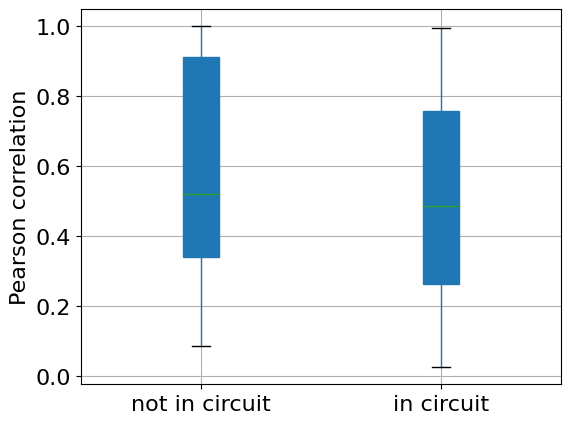

In [12]:
pearson_df = pd.DataFrame({
    "pearson": [pearson_vals for pearson_vals in normalised_siit_stats["pearson"].values],
    "p_value": normalised_siit_stats["p_value"].values,
    "ones": [1 if status == "in_circuit" else 0 for status in normalised_siit_stats["status"].values],
    "status": normalised_siit_stats["status"].values
})
fig = pearson_df.boxplot(
    column="pearson", 
    by="status",
    patch_artist=True,
    showfliers=True,
    # whis=[5, 95],
)
import matplotlib.pyplot as plt

plt.suptitle("")
plt.title("")

plt.xticks(
    ticks=[1, 2],
    labels=["not in circuit", "in circuit"],
    fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("")
plt.ylabel("Pearson correlation", fontsize=16)
fig.get_figure().set_size_inches(6, 5)

plt.show()

# save the figure
fig.get_figure().savefig(f"interp_results/pearson_plots/siit_{lens}_pearson_boxplot.pdf", bbox_inches='tight')

In [16]:
siit_stats[siit_stats["run"] == 4]

,run,node,status,resample_ablate_effect,zero_ablate_effect,norm_cache,norm_std,grad_norm,grad_std
150,4,"blocks.0.attn.hook_result, head 0",not_in_circuit,0.000042,0.979,0.762064,0.052615,0.000084,2.873757e-06
151,4,"blocks.0.attn.hook_result, head 1",not_in_circuit,0.000000,1.000,0.500946,0.024056,0.000084,2.873757e-06
152,4,"blocks.0.attn.hook_result, head 2",not_in_circuit,0.000000,0.027,0.501463,0.048098,0.000084,2.873757e-06
153,4,"blocks.0.attn.hook_result, head 3",not_in_circuit,0.000000,0.000,0.337975,0.031287,0.000084,2.873757e-06
154,4,"blocks.1.attn.hook_result, head 2",not_in_circuit,0.000000,0.905,1.015392,0.046711,0.000037,1.291264e-06
155,4,"blocks.1.attn.hook_result, head 3",not_in_circuit,0.000000,0.596,0.750994,0.063240,0.000037,1.291264e-06
156,4,blocks.0.mlp.hook_post,in_circuit,0.987728,0.978,2.660494,0.121208,0.000051,1.816633e-06
157,4,"blocks.1.attn.hook_result, head 0",in_circuit,0.737934,0.821,0.947983,0.220224,0.000037,1.291264e-06
158,4,"blocks.1.attn.hook_result, head 1",in_circuit,0.722296,0.892,1.102349,0.178876,0.000037,1.291264e-06
159,4,blocks.1.mlp.hook_post,in_circuit,0.987728,0.977,4.158234,0.433755,0.000021,7.484468e-07
